In [1]:
!nvidia-smi

Fri Nov 13 15:00:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. tfrecord load

In [3]:
tfr_train_dir = '/content/drive/Shared drives/GOFOODA/data/food_data.tfr'

raw_image_dataset = tf.data.TFRecordDataset(tfr_train_dir)

# Create a dictionary describing the features.
image_feature_description = {
    'image' : tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {image: (), label: ()}, types: {image: tf.string, label: tf.int64}>

기존에 tfrecord에 담겨있는 이미지는 bytes형태로 저장되어 있기 때문에 이를 tensor로 읽어들이기 위해선 ```tf.image.decode_jpeg```를 활용한다

tf.Tensor(22, shape=(), dtype=int64)


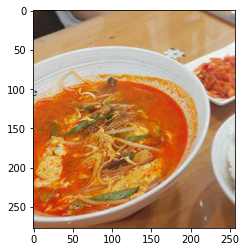

tf.Tensor(22, shape=(), dtype=int64)


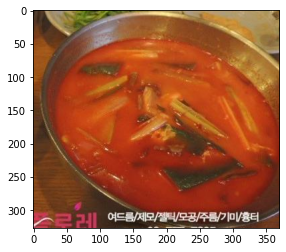

tf.Tensor(22, shape=(), dtype=int64)


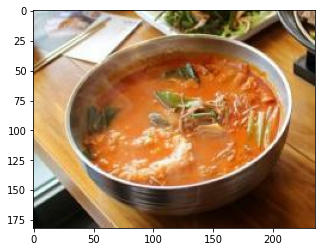

tf.Tensor(22, shape=(), dtype=int64)


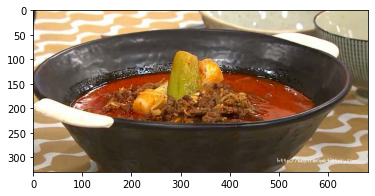

tf.Tensor(22, shape=(), dtype=int64)


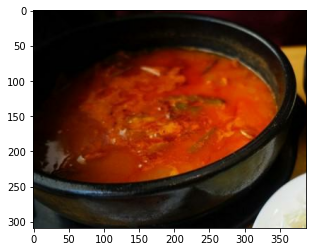

In [4]:
for image_features in parsed_image_dataset.take(5):
    print(image_features['label'])
    image_raw = image_features['image'].numpy()
    plt.imshow(tf.image.decode_jpeg(image_raw))
    plt.show()

[dataset을 split하는 방법](https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test)
- 기존에 데이터가 섞여있지 않은 채로 Dataset으로 만들어져 있기 때문에 위와 같은 방법으로 train(8), valid(1), test(1)로 나눈다.

In [5]:
DATASET_SIZE = 23484
BATCH_SIZE = 128
IMAGE_SIZE = 224

In [6]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

In [7]:
dataset = parsed_image_dataset.shuffle(DATASET_SIZE)
# train
train_ds = dataset.take(train_size)
# valid
valid_ds = dataset.skip(train_size)
valid_ds = dataset.take(val_size)
# test
test_ds = valid_ds.skip(val_size)
test_ds = valid_ds.take(test_size)

In [8]:
def decode_img(data):
    image = data['image']
    label = data['label']

    image = tf.image.decode_image(image, channels=3, expand_animations = False)
    # image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (224, 224))
    
    label = tf.one_hot(label, 30)

    return image, label

In [9]:
train_ds = train_ds.map(decode_img)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.repeat()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
valid_ds = valid_ds.map(decode_img)
valid_ds = valid_ds.batch(BATCH_SIZE)

# 모델 생성
---
기존의 EfficientNetB0모델을 가져온다.

In [11]:
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
    )

In [12]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [13]:
flatten_layer = tf.keras.layers.Flatten()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(30, activation='softmax')

model = tf.keras.Sequential([
                             base_model,
                             flatten_layer,
                             dense_layer,
                             prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
dense_1 (Dense)              (None, 30)                15390     
Total params: 36,178,113
Trainable params: 36,136,090
Non-trainable params: 42,023
_________________________________________________________________


In [14]:
mc_dir_path = '/content/drive/Shared drives/GOFOODA/data/EfficentNetB0_checkpoint/'
mc_path = os.path.join(mc_dir_path, 'EfficientNet-002.h5')

In [15]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=mc_dir_path+'{epoch}-{val_loss:.2f}-{val_accuracy:.2f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    )

In [16]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=100,
    validation_data = valid_ds,
    steps_per_epoch=DATASET_SIZE//BATCH_SIZE,
    callbacks=[es, mc]
)

Epoch 1/100
183/183 [==============================] - ETA: 0s - loss: 1.0187 - accuracy: 0.7373
Epoch 00001: val_accuracy improved from -inf to 0.85349, saving model to /content/drive/Shared drives/GOFOODA/data/EfficentNetB0_checkpoint/1-0.48-0.85.h5
183/183 [==============================] - 115s 629ms/step - loss: 1.0187 - accuracy: 0.7373 - val_loss: 0.4810 - val_accuracy: 0.8535
Epoch 2/100
183/183 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.8882
Epoch 00002: val_accuracy improved from 0.85349 to 0.91567, saving model to /content/drive/Shared drives/GOFOODA/data/EfficentNetB0_checkpoint/2-0.31-0.92.h5
183/183 [==============================] - 111s 608ms/step - loss: 0.3745 - accuracy: 0.8882 - val_loss: 0.3101 - val_accuracy: 0.9157
Epoch 3/100
183/183 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.9232
Epoch 00003: val_accuracy improved from 0.91567 to 0.92206, saving model to /content/drive/Shared drives/GOFOODA/data/Efficent

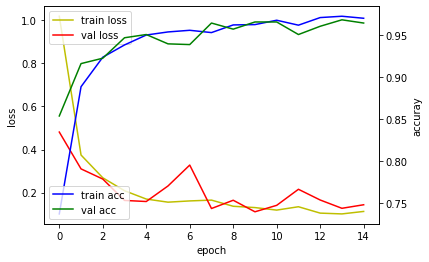

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.savefig('/content/drive/Shared drives/GOFOODA/data/EfficentNetB0_checkpoint/result.png')
plt.show()

## Test

In [18]:
import tensorflow as tf
import os
from glob import glob
import numpy as np

In [39]:
model = tf.keras.models.load_model('/content/drive/Shared drives/GOFOODA/data/EfficentNetB0_checkpoint/14-0.13-0.97.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
dense_1 (Dense)              (None, 30)                15390     
Total params: 36,178,113
Trainable params: 36,136,090
Non-trainable params: 42,023
_________________________________________________________________


In [40]:
add_food_lst = os.listdir('/content/drive/Shared drives/GOFOODA/ty_food/')
classes = glob('/content/drive/Shared drives/GOFOODA/data/food30/*/*')
classes = list(map(lambda x : x.split('/')[-2], classes))
classes = classes + add_food_lst
classes = list(np.unique(classes))

In [41]:
classes.sort()
label_dict = {}
for idx, value in enumerate(classes) :
    label_dict[idx] = value
label_dict

{0: '갈비구이',
 1: '갈비탕',
 2: '갈치구이',
 3: '갈치조림',
 4: '감자탕',
 5: '계란말이',
 6: '고추튀김',
 7: '곰탕_설렁탕',
 8: '곱창전골',
 9: '김밥',
 10: '김치볶음밥',
 11: '김치전',
 12: '김치찌개',
 13: '닭볶음탕',
 14: '된장찌개',
 15: '만두',
 16: '비빔밥',
 17: '삼겹살',
 18: '새우볶음밥',
 19: '생선전',
 20: '소세지볶음',
 21: '양념치킨',
 22: '육개장',
 23: '육회',
 24: '제육볶음',
 25: '짬뽕',
 26: '찜닭',
 27: '파전',
 28: '피자',
 29: '후라이드치킨'}

In [42]:
test_imgs = glob('/content/drive/Shared drives/GOFOODA/data/test_HR/*/*')
test_imgs[:5], len(test_imgs)

(['/content/drive/Shared drives/GOFOODA/data/test_HR/김치볶음밥HR/김치볶음밥4.jpg',
  '/content/drive/Shared drives/GOFOODA/data/test_HR/김치볶음밥HR/김치볶음밥2.jpg',
  '/content/drive/Shared drives/GOFOODA/data/test_HR/김치볶음밥HR/김치볶음밥6.jpg',
  '/content/drive/Shared drives/GOFOODA/data/test_HR/김치볶음밥HR/김치볶음밥7.jpg',
  '/content/drive/Shared drives/GOFOODA/data/test_HR/김치볶음밥HR/김치볶음밥5.jpg'],
 112)

In [43]:
test_ds = tf.data.Dataset.from_tensor_slices(test_imgs)

In [44]:
def open_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (224,224))
    return img

In [45]:
test_ds = test_ds.map(open_img)

In [46]:
logits = model.predict(test_ds)

In [47]:
logits.shape

(112, 30)

In [48]:
logits[0]

array([9.0229571e-02, 4.3200216e-06, 7.7925101e-03, 8.5143581e-02,
       3.6647586e-07, 2.4110918e-01, 3.2765630e-03, 4.0668585e-08,
       2.3839034e-07, 6.2243894e-02, 5.6373077e-03, 4.1992036e-01,
       1.2599057e-06, 2.0092007e-04, 6.7014616e-07, 4.8782667e-06,
       1.1158980e-05, 3.9548097e-05, 1.1963522e-06, 3.5707475e-04,
       1.2525671e-05, 6.0863484e-02, 2.3079677e-03, 1.1221073e-04,
       2.6125938e-04, 2.2633714e-07, 3.3945085e-08, 1.5329897e-02,
       6.6661116e-05, 5.0710761e-03], dtype=float32)

In [49]:
label_dict[np.argmax(logits[0])]

'김치전'

In [50]:
from PIL import Image
import matplotlib.pyplot as plt

김치볶음밥


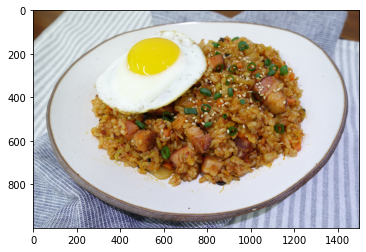

김치볶음밥


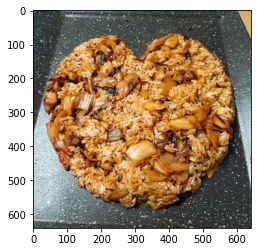

감자탕


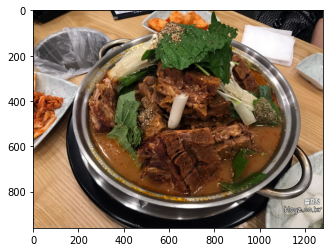

감자탕


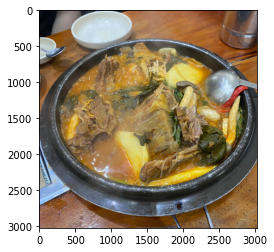

감자탕


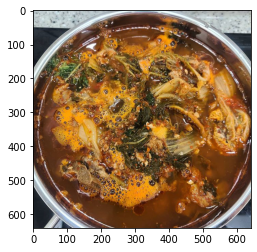

찜닭


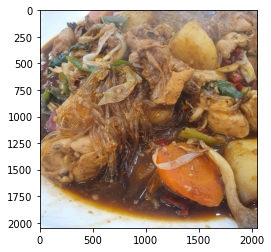

찜닭


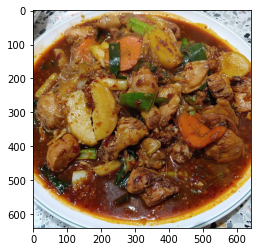

갈비구이


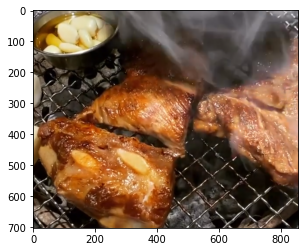

갈치구이


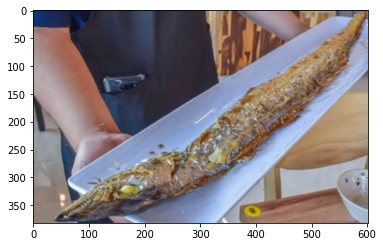

김치찌개


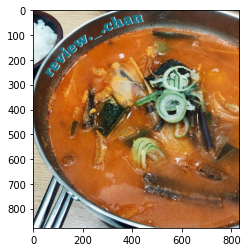

삼겹살


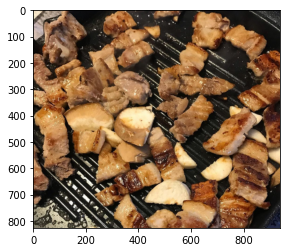

삼겹살


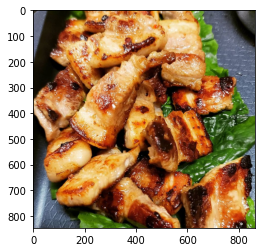

In [51]:
for i, logit in enumerate(logits) :
    if i % 10 != 1:
        continue
    img = Image.open(test_imgs[i])
    img = np.array(img)
    print(label_dict[np.argmax(logit)])
    plt.imshow(img)
    plt.show()